In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab5.ipynb")

# Coding lab \#5

```{grid} 2 2 2 2 
**2D elements \& numerical quadrature**
:::{figure} figures/AshesiETHLogo.png
:align: right
:width: 300px
:::
```

:::{admonition} How to use this notebook?
This notebook is made of text cells and code cells. The code cells have to be **executed** to see the result of the program. \
To execute a cell, simply select it and click on the "play" button \(&#9658;\) in the tool bar just above the notebook, or type `shift+enter`
It is important to execute the code cells in their order of appearance in the notebook.

**As a first step**: execute the very first OtterGrader code cell at the very top of this notebook. 

If you are running into any problems, try restarting the kernel and then see if the issue persist. 
:::

## Learning goals

After using this notebook, you should be able to:
* do FE computations under the plane stress assumption using Q4 elements
* understand and implement numercial integration via Gauss-Legendre quadrature

## Problem statement

The objective of this project is to write your own finite element code to simulate linear elastic boundary value problems in 2D (under plane stress assumptions). 
Plane stress means that we are dealing with a thin object loaded within its own median plane. 
To  model these structures, we will use 4-node bilinear quadrilateral elements (also known as Q4), whose formulation was derived in *Section 17* of the lecture notes. We will require numerical quadrature in this project, see *Section 19.2.1* in the lecture notes for details. Some points to be aware of when working with Q4 elements are discussed in *Section 22* of the lecture notes.

___
## Problem 1 a)

Let us consider a simple beam bending problem as shown below. 
We have a cantilever, which is fully clamped on the right-hand-side (along $x_1 = a$).
We shall model the force acting on this beam as a distributed load applied at ($x_1 = [0,L]$, $x_2 = b/2$). 
The aim of this problem is to solve this beam problem using Q4 elements and using *full* integration and analysing what happens when we change the height of this cantilever, while comparing our finite element solution to the result of classical Euler-Bernoulli beam theory. 


```{figure} figures/beam.png
:name: roadSign
:alt: figure - beam bending
:class: bg-primary
:width: 400px
:align: center

```

Minimum input is required from you to define the problem parameters: 
Young's modulus and Poisson's ratio ($E_y = 200$GPa and $\nu = 0.3$), respectively, are already given in the input and the area moment of inertia $I$ is also computed for you. 
Further, the distributed load applied ($\boldsymbol{f}$, with the units of a pressure) is determined in the input already, as it is scaled depending on the beam thickness to achieve a similar deflection at all times. 

We shall model the beam with dimensions $a = 10$m, $b=3$m and out-of-plane thickness $t = 0.1$m. 

:::{admonition} submission requirement
:class: tip

Follow the intstructions in the coding section below and input all missing information as indicated, to solve this problem under the plane stress assumption using Q4 elements and full integration.
:::



___

# Coding

For this, we need to import some useful Python libraries.

**Execute the code cell below** so that the necessary libraries are imported.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lib.plottingFunctions import *
from lib.problem1_input import *
# Enable inline plotting in Jupyter Notebook
%matplotlib inline
# And display a message once all libraries are imported
print("Libraries imported.")

Libraries imported.


### pre-processing

In this lab we retrieve from the input the Neumann boundary conditions (accounting for the distributed load) in a more general way: instead of already definining the equivalent force applied to each node as done in lab 4, we know the elements and their corresponding edge (0,1,2,3) where the traction $\boldsymbol{f}$ is applied.

Fill out the missing information in the input section:

In [3]:
# TODO: fill in the beam height b in metres
b = 3 

# given:
a = 10    # beam length given as 10m at all times
t = 0.1   # out of plane thickness given as 0.1m at all times

# the input function provides:
# - Young's modulus Ey
# - Poisson's ratio v
# - area moment of inertia I 
# the well known arrays containing 
# - the Dirichlet boundary conditions Dirichlet_BCs
# - the Neumann nodal boundary conditions Neumann_BCs (here empty, as we have no point loads)
# - nodal_positions (containing the [x1 x2] per node)
# - nodal_connectivities (containing the [node1e node2e node3e node4e] per element)
# information on the distributed load
# - the distributed load f_x2 (containing the component of f along x2)
# - the elements' IDs and their local edges IDs involved in Neumann boundary conditions DistributedNeumann_BCs with traction f
#      (e.g. assume element 42 has 4 edges: 0,1,2,3, and its edge 2 is loaded by f = [f_x1, f_x2]
#       -> NeumannBCsElementsEdges has a row with entries 42,2,f_x1,f_x2)

nodal_positions, nodal_connectivities, Dirichlet_BCs, Neumann_BCs, DistributedNeumann_BCs, Ey, v, I, f_x2 = \
    problem1_input(a,b,t)

### set-up

This should be familiar to you by now: for this lab you are only asked to 
- construct the material matrix $\boldsymbol{E}_{\text{plane stress}}$ 
- define the Gauss-Legendre quadrature points and quadrature_weights required for full integration 

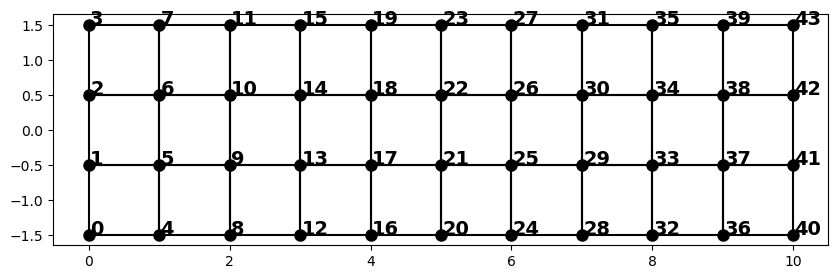

In [4]:
# ----------------------------------------------------------------------------------------------------------#
#                                          Set up FE
# ----------------------------------------------------------------------------------------------------------#

# given:
no_dofs_per_node    = 2  # number of dofs per node
no_global_nodes     = nodal_positions.shape[0]  # number of global nodes
no_global_dofs      = no_global_nodes * no_dofs_per_node  # number of global dofs
no_dofs_per_element = 4 * no_dofs_per_node
no_elements         = nodal_connectivities.shape[0]  # number of elements
no_Neumann_BCs      = Neumann_BCs.shape[0]  # number of external loads applied
no_Dirichlet_BCs    = Dirichlet_BCs.shape[0]  # number of Dirichlet boundary conditions

# given: Initialize global vectors and matrices
global_stiffness_matrix = np.zeros((no_global_dofs, no_global_dofs))
global_force_vector = np.zeros((no_global_dofs, 1))

# given: write out elementDofConnectiviy for a Q4 element:
nodes1 = nodal_connectivities[:, 0]
nodes2 = nodal_connectivities[:, 1]
nodes3 = nodal_connectivities[:, 2]
nodes4 = nodal_connectivities[:, 3]
element_dof_connectivity = np.column_stack([nodes1 * 2, nodes1 * 2 + 1, nodes2 * 2, nodes2 * 2 + 1,nodes3 * 2, nodes3 * 2 + 1,nodes4 * 2, nodes4 * 2 + 1]).astype(int)

# TODO: construct the material matrix for plane stress:
E_matrix = (Ey/(1-v**2))*np.array([[1,v,0],
                                   [v,1,0],
                                   [0,0,(1-v)/2]
                                  ])

# TODO fill out two arrays:
# 1. quadrature_points: containing the two Quadrature Points
# 2. quadrature_weights:          containing the corresponding quadrature_weights.
# we are using full integration: so we are using two quadrature points per xi and eta direction, respectively
# hint: recall the useful numpy function np.sqrt(x)  
no_quadrature_points  = 2  # given: number of quadrature points in 1D (i.e. number of quadrature points in xi and eta direction, respectively)
quadrature_points  = np.array([-1/(np.sqrt(3)),1/(np.sqrt(3))])
quadrature_weights = np.array([1,1])

# given: a plot of the initial structure:
plot_initial_structure(no_elements,nodal_connectivities,no_global_nodes,nodal_positions)

In [5]:
grader.check("setUpFE")

setUpFE results: All test cases passed!
setUpFE - 1 message: checking the Gauss quadrature_points and quadrature_weights - nice, your two Gauss quadrature_points and quadrature_weights are correct.
setUpFE - 2 message: checking the plane stress matrix - nice, your plane stress matrix is correct.

### define functions

As we have seen in the previous Coding Labs, let's write some functions to make our life easier later on, when we are required to compute the element stiffness matrix and the equivalent nodal forces vector, this time making use of Gauss-Legendre quadrature, so that we will be computing

$$
\boldsymbol{K}_e = \int_{\Omega_e} \boldsymbol{B}^{\text{T}}_e(\xi, \eta) \, \boldsymbol{E} \, \boldsymbol{B}_e(\xi, \eta)  \,t\text{d} A
\approx \sum_{i=0}^{noQP-1} \sum_{j=0}^{noQP-1}W_i\,W_j\,\boldsymbol{B}^{\text{T}}_e(\xi_i, \eta_j) \, \boldsymbol{E} \, \boldsymbol{B}_e(\xi_i, \eta_j) \, \text{det}\left(\boldsymbol{J}_e(\xi_i, \eta_j)\right)  \,t.
$$

Similarily, the contribution to the external force vector from element $e$ will be

$$
\boldsymbol{F}_{\text{ext},e} = \int_{\partial \Omega_{e}}\boldsymbol{N}_e^{\text{T}}\boldsymbol{f}\,\text{d} S \approx \sum_{k=0}^{noQP-1} W_k\,\boldsymbol{N}_e^{\text{T}}(\zeta_k)\,\boldsymbol{f}(\zeta_k)\,J_{\zeta}(\zeta_k)\,t.
$$

where $J_{\zeta}$ is the Jacobian of the 1D interpolation along the edge, parametrized with $\zeta$.


Fill out the missing information below to compute:
- the determinant of the $\boldsymbol{J}_e$-matrix and the $\boldsymbol{B}_e$- matrix (per element) for our Q4 elements for a specific value of $(\xi, \eta)$ that we send into this function (we will use this to compute the local stiffness matrix);
- the Jacobian $J_{\zeta}$ and the $\boldsymbol{N}_e$- matrix computed on a given surface (edge) for a specific value $\zeta$ on the element edge (we will use this to compute the element force vector).

In [6]:
def Q4_functions_interior(xi, eta, elm_nodal_connectivities):

    # write your code here to compute det(Je) and the Be-matrix per element,
    # using the inputs provided: namely the Gauss points xi and eta, as well as the nodal connectivities  
    # which are the four nodes associated with the current element. i.e. [node1e, node2e, node3e, node4e]
    # in this function you can make use of the nodal_positions array that was defined in the input 
    # (there is no need to send this into the function as the nodal_positions are already defined at the beginning)
    
    N_mat = (1/4)*np.array([[-(1-eta),(1-eta),(1+eta),-(1+eta)],
                            [-(1-xi),-(1+xi),(1+xi),(1-xi)]
                           ])

    coord = nodal_positions[elm_nodal_connectivities]

    Je = N_mat @ coord

     
    detJe = np.linalg.det(Je) 

    gamma = np.linalg.inv(Je)

    B1 = np.array([[1,0,0,0],
                   [0,0,0,1],
                   [0,1,1,0]
                  ])

    gamma_zero = np.zeros((2,2))
    
    B2 = np.block([[gamma,gamma_zero],
                  [gamma_zero,gamma]])
    
    N1 = N_mat[:,0].reshape(2,1)
    N2 = N_mat[:,1].reshape(2,1)
    N3 = N_mat[:,2].reshape(2,1)
    N4 = N_mat[:,3].reshape(2,1)

    N_zero = np.zeros((2)).reshape(2,1)

    B3 = np.block([[N1,N_zero,N2,N_zero,N3,N_zero,N4,N_zero],
                   [N_zero,N1,N_zero,N2,N_zero,N3,N_zero,N4]
                  ])
    Be = B1@B2@B3 


    return detJe, Be

In [7]:
grader.check("Q4_functions_interior")

Q4_functions_interior results: All test cases passed!
Q4_functions_interior - 1 message: nice, it seems like you are computing detJe correctly in Q4_functions_interior.
Q4_functions_interior - 2 message: nice, it seems like you are computing Be correctly in Q4_functions_interior.

In [8]:
def Q4_functions_boundary(zeta, edge_id, elm_nodal_connectivities):

    # write your code here to compute J_zeta and the Ne-matrix per element,
    # using the inputs provided: namely the 1D Gauss points zeta, the local edge_id as well as the nodal connectivities  
    # which are the four nodes associated with the current element. i.e. [node1e, node2e, node3e, node4e]
    # in this function you can make use of the nodal_positions array that was defined in the input 
    # (there is no need to send this into the function as the nodal_positions are already defined at the beginning)

    # Parametrize edge in reference coordinates
    # Here we just retrieve the 2D coordinates xi and eta given the 1D coordinate zeta
    if edge_id == 0:  # bottom edge
        xi, eta = zeta, -1
        dxi_dzeta = 1
        deta_dzeta = 0
    elif edge_id == 1:  # right edge
        xi, eta = 1, zeta
        dxi_dzeta = 0
        deta_dzeta = 1
    elif edge_id == 2:  # top edge
        xi, eta = -zeta, 1
        dxi_dzeta = -1
        deta_dzeta = 0
    elif edge_id == 3:  # left edge
        xi, eta = -1, -zeta
        dxi_dzeta = 0
        deta_dzeta = -1
    else:
        raise ValueError("edge_id must be 0, 1, 2, or 3")

    # Shape functions matrix (2x8)
    N1 = 0.25*(1-xi)*(1-eta)
    N2 = 0.25*(1+xi)*(1-eta)
    N3 = 0.25*(1+xi)*(1+eta)
    N4 = 0.25*(1-xi)*(1+eta)
    
    Ne = np.array([[N1,0,N2,0,N3,0,N4,0],
                   [0,N1,0,N2,0,N3,0,N4]
                  ])

    # Jacobian of the full 2D mapping (as computed in Q4_functions_boundary)
    N_mat = (1/4)*np.array([[-(1-eta),(1-eta),(1+eta),-(1+eta)],
                            [-(1-xi),-(1+xi),(1+xi),(1-xi)]
                           ])

    coord = nodal_positions[elm_nodal_connectivities]

    Je = N_mat @ coord

    # Tangent vector along the edge in physical space (2x1 vector telling how x1 and x2 vary with respect to zeta)
    dx_dzeta = Je.T @ np.array([dxi_dzeta, deta_dzeta])

    # Jacobian of the 1D interpolation
    J_zeta = np.linalg.norm(dx_dzeta)

    return J_zeta, Ne

In [9]:
grader.check("Q4_functions_boundary")

Q4_functions_boundary results: All test cases passed!
Q4_functions_boundary - 1 message: nice, it seems like you are computing J_zeta correctly in Q4_functions_boundary.
Q4_functions_boundary - 2 message: nice, it seems like you are computing Ne correctly in Q4_functions_boundary.

Applying the boundary conditions and solving is given here in a function. We wrote this completely generically, **so no changes are required**. You can click on the three dots (or blue bar) to expand and see details of the function.

In [10]:
 def apply_BCs_and_solve(global_stiffness_matrix, global_force_vector, no_Neumann_BCs, Neumann_BCs, no_Dirichlet_BCs, Dirichlet_BCs,
                          no_dofs_per_node, no_global_dofs):
    global_displacement_vector = np.zeros(no_global_dofs)
    # Apply Neumann BCs:
    for load_index in range(no_Neumann_BCs): 
        dof = int(no_dofs_per_node * Neumann_BCs[load_index, 0] - no_dofs_per_node + Neumann_BCs[load_index, 1])+no_dofs_per_node
        global_force_vector[dof] += Neumann_BCs[load_index, 2]

    # Apply Dirichlet/essential BCs:
    # Make a copy of K to enforce the essential bcs 
    K = global_stiffness_matrix.copy()

    for disp_index in range(no_Dirichlet_BCs):
        # Find essential boundary condition dof
        dof = int(no_dofs_per_node * Dirichlet_BCs[disp_index, 0] - no_dofs_per_node + Dirichlet_BCs[disp_index, 1])+no_dofs_per_node
        # Enforce essential boundary condition
        K[dof, :] = 0
        K[dof, dof] = 1.0
        global_force_vector[dof] = Dirichlet_BCs[disp_index, 2]
        global_displacement_vector[dof] = Dirichlet_BCs[disp_index,2]

    # Solve for displacement:
    global_displacement_vector = np.linalg.solve(K, global_force_vector)
    # Solve for reaction forces:
    global_force_vector = np.dot(global_stiffness_matrix, global_displacement_vector)

    return global_displacement_vector, global_force_vector

### assemble global stiffness matrix and equivalent nodal force vector

Loop over all elements and compute the elemental stiffness matrices and assemble these to the correct positions into the global stiffness matrix. Be careful: this time we have to compute an integral to determine $\boldsymbol{K}_e$.

Similarily, loop over each row of DistributedNeumann_BCs and compute $\boldsymbol{F}_{\text{ext},e}$.

In [11]:
# ----------------------------------------------------------------------------------------------------------#
#                                             ASSEMBLE K and F
# ----------------------------------------------------------------------------------------------------------#
# Assemble global stiffness matrix
# Loop over all elements -> compute elemental stiffness matrix -> assemble global stiffness matrix


for e in range(no_elements):
    element_stiffness_matrix = np.zeros((no_dofs_per_element,no_dofs_per_element)) # start with a zero element stiffness matrix per element
    elm_nodal_connectivities = nodal_connectivities[e, :] # you require the nodal connectivities per element for the function you defined above. 
    # TODO: compute element_stiffness_matrix = ... 
    for i,xi in enumerate(quadrature_points):
        for j,eta in enumerate(quadrature_points):
            Wi = quadrature_weights[i]
            Wj = quadrature_weights[j]
            detJe, Be = Q4_functions_interior(xi, eta, elm_nodal_connectivities)
            element_stiffness_matrix +=(Be.T@E_matrix@Be)*Wi*Wj*detJe*t
            
            
    # given: (as before) assemble Ke into Kglobal
    global_stiffness_matrix[np.ix_(element_dof_connectivity[e], element_dof_connectivity[e])] += element_stiffness_matrix

# Assemble global force vector from distributed Neumann boundary conditions
# Loop over all edges in DistributedNeumann_BCs -> compute local force vector -> assemble global force vector
# (Hint: you can reassemble the 2x1 traction vector with np.array([f_x1,f_x2])

for e, edge_id, f_x1, f_x2 in DistributedNeumann_BCs:
    element_force_vector = np.zeros(no_dofs_per_element) # start with a zero element nodal force vector per element
    elm_nodal_connectivities = nodal_connectivities[e, :] # you require the nodal connectivities per element for the function you defined above 
    traction = np.array([f_x1,f_x2])
    # TODO: compute element_force_vector = ...
    for k,zeta in enumerate(quadrature_points):
        Wk = quadrature_weights[k]
        J_zeta, Ne = Q4_functions_boundary(zeta, edge_id, elm_nodal_connectivities)
        element_force_vector+=(Ne.T@traction)*Wk*J_zeta*t
    # given: (as before) assemble Fe into Fglobal
    global_force_vector[element_dof_connectivity[e], 0] += element_force_vector


### apply BC's and solve problem
Enforcing the essential and natural boundary conditions and computing the global displacement and force vectors.
**Note:** Since we wrote this section generically in the previous projects, we can reuse it here and **do not have to apply any changes**, regardless if we use bar or beam or CST or Q4 elements. We simply make use of the function we defined earlier on. Execute the code cell below.

In [12]:
# ----------------------------------------------------------------------------------------------------------#
#                                               APPLYING BCs & SOLVING
# ----------------------------------------------------------------------------------------------------------#
# The computation of the global displacement and force vectors does not require any changes.
global_displacement_vector, global_force_vector = apply_BCs_and_solve(global_stiffness_matrix,global_force_vector,
                                                                    no_Neumann_BCs, Neumann_BCs, no_Dirichlet_BCs,
                                                                    Dirichlet_BCs, no_dofs_per_node, no_global_dofs)
# ----------------------------------------------------------------------------------------------------------#

### post-process

Once you computed all nodal displacements and forces, we do some post-processing:
- use the provided plotting function to plot the initial and deformed structure.
- take a look at the comparison between your FE results and the Euler-Bernoulli beam results (few percent error is to expect)

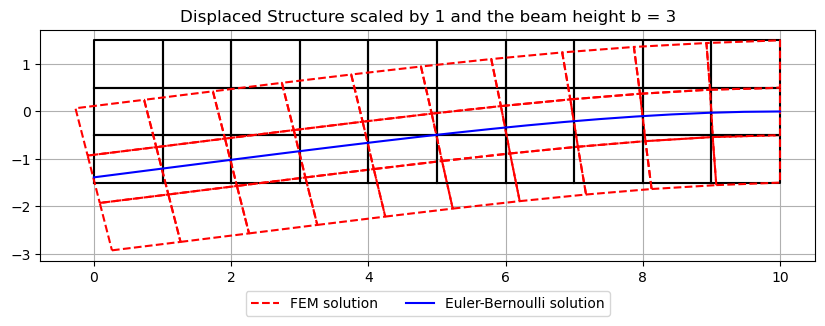

-----------------------------------------------------------------

 vertical displacement at node 0 = -1.429

 vertical deflection of Euler-Bernoulli beam = -1.389

 error between Euler-Bernoulli beam vs FE simulation result = 2.857 %


In [13]:
# ----------------------------------------------------------------------------------------------------------#
#                                        POST-PROCESSING
# ----------------------------------------------------------------------------------------------------------#
plot_initial_FEM_and_EB(global_displacement_vector,nodal_positions,Ey,a,b,t,I,f_x2,nodal_connectivities,no_elements)


<!-- BEGIN QUESTION -->

# Problem 1 b)

:::{admonition} submission requirement
:class: tip
Re-run your code with the beam height $b = 0.03$. 

What do you observe? Explain what you observe when you run your code with $b=3$ and $b=0.03$ in the space below. 

Further, explain the phenomena you observe and why it is happening.

Finally, describe how this behavior can be avoided.
:::

For b = 3, the Finite Element (FEM) results closely match the analytical Euler-Bernoulli beam solution, and the vertical displacement at the free end differs only by 2.857 %, which indicates that the Q4 finite elements correctly capture both bending and shear deformation. However, for b=0.03, the FEM solution becomes almost completely rigid compared to the analytical Euler-Bernoulli result, with a discrepancy of 99.766%. This implies that the FEM model fails to represent the actual bending behaviour of the slender beam.

The reason for this discrepancy is a phenomenon called "shear locking". In very slender beams (where the thickness-to-length ratio is small), the true shear deformation is almost zero. However, a 4-node quadrilateral (Q4) elements with full integration artificially constrain the shear strain field, which over-stiffens the element and suppresses bending deformation, making the model appear much stiffer that it should.

This behaviour can be avoided by using reduced integration, higher-order elements (such as Q8), or mesh refinement.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

***

## Closing remarks

When you reach this part of the script, your code should be running just fine.  
Further, you have taken some time to interpret some of the results. 

To close off this assignment on Q4 elements, write down three points of what you have learned during this project in the provided space below.

As a final point, you can also give an indication of how long it took you to complete this assignment. 

- I learned how to do FEM computations under the plane stress assumption using Q4 elements.
- I learned how to implement numerical integration using Gauss-Legendre quadrature.
- I understood how shear locking can significantly affect FEM accuracy, especially in thin or slender structures.

In [14]:
grader.check("Check saved b = 3 for submission")

Check saved b = 3 for submission results: All test cases passed!
Check saved b = 3 for submission - 1 message: great, you ran your code with b = 3 as required for submission.

<!-- END QUESTION -->

:::{admonition} important
:class: attention

**Run** and **save** your code with beam height **b = 3** before submitting through Moodle!

Best of luck!

:::